## Portfolio Factor Analysis

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, SpectralEmbedding
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Function block

### REPRESENTATION LEARNING METHODS
def linPCA(train_data, tune_data, n_components):
    """
    Function to apply linear PCA with specified number of components. 
    Input:
        train_data (ndarray): dataset used to fit linear PCA model
        tune_data (ndarray): dataset transformed by linear PCA model
        n_components (int): hyperparameter specifying number of components
    Output:
        Z (ndarray): tune_data transformed to PCA subspace
    """
    pca = PCA(n_components=n_components)
    pca.fit(train_data)
    Z = pca.transform(tune_data)
    
    return Z

def KPCA(train_data, tune_data, n_components, kernel='poly', gamma=None, degree=3):
    """
    Function to apply Kernel PCA with specified number of components. 
    Input:
        train_data (ndarray): dataset used to fit kernel PCA model
        tune_data (ndarray): dataset transformed by kernel PCA model
        n_components (int): hyperparameter specifying number of components
        kernel (str): kernel method; choose from {"poly" | "rbf" | "sigmoid" | "cosine"}
        gamma (int): gamma coefficient for rbf, poly, and sigmoid kerenels
        degree (int): degree of polynomial for poly kernel
    Output:
        Z (ndarray): tune_data transformed to PCA subspace
    """
    kpca = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, degree = degree)
    kpca.fit(train_data)
    Z = kpca.transform(tune_data)
    
    return Z

def isomap(train_data, tune_data, n_components, n_neighbors):
    """
    Function to apply Isomap with specified number of components. 
    Input:
        train_data (ndarray): dataset used to fit Isomap model
        tune_data (ndarray): dataset transformed by Isomap model
        n_components (int): hyperparameter specifying number of components
        n_neighbors (int): hyperparameter specifying number of neighbors to construct initial mapping
    Output:
        Z (ndarray): tune_data transformed to subspace
    """
    embedding = Isomap(n_components=n_components, n_neighbors=n_neighbors)
    embedding.fit(train_data)
    Z = embedding.transform(tune_data)
    
    return Z

def spectral(train_data, n_components, affinity, gamma = None, n_neighbors = None):
    """
    Function to apply SpectralEmbedding with specified number of components. 
    Input:
        train_data (ndarray): dataset used to fit Spectral Embedding model
        n_components (int): hyperparameter specifying number of components
        affinity (str): designation of affinity matrix; choose from {'nearest_neighbors'|'rbf'|'precomputed'}
        gamma(int): coefficient for rbf kernel, if used
        n_neighbors (int): hyperparameter specifying number of neighbors to construct knn map, if used

    Output:
        Z (ndarray): tune_data transformed to subspace
    """
    embedding = SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors, affinity = affinity, gamma = gamma)
    Z= embedding.fit_transform(train_data)
    
    return Z
    
    
### REGRESSION TEST
def LinRegression(X,y,autocor = None):
    """
    Runs simple linear regression on the dataset provided and returns the model's R^2 value.
    Input:
        X (DataFrame): predictor data
        y (DataFrame): outcome data
        autocor: number of periods for autocorrelation correction (default = None)
    Output:
        R^2 value for model (real)
    
    """
    if autocor:
        for i in range(1,autocor + 1):
            X.join(y.shift(i))
        X = X.iloc[autocor::,:] # removing the rows that don't have lagged returns
        y = y.iloc[autocor::]
    reg = LinearRegression().fit(X,y)        
    return reg.score(X,y)

### Import Data

Read in Excel file and specifically import net returns data

In [3]:
xls=pd.ExcelFile('Simple_Strategies_Returns.xlsx')
grossreturns = pd.read_excel(xls, 0)
netreturns = pd.read_excel(xls, 1)

In [4]:
#Keep all data, but get rid of factors with missing data
netreturns = netreturns.dropna(axis=1).copy()
netreturns['Month'] = pd.to_datetime(netreturns['Month'], format = '%Y%m')
netreturns['Month'] = netreturns['Month'].dt.to_period('M')
netreturns['Month'] = netreturns['Month'].astype('str')

grossreturns = grossreturns.dropna(axis=1).copy()
grossreturns['Month'] = pd.to_datetime(grossreturns['Month'], format = '%Y%m')
grossreturns['Month'] = grossreturns['Month'].dt.to_period('M')
grossreturns['Month'] = grossreturns['Month'].astype('str')

In [82]:
netreturns.shape

(606, 25)

Split data into 'new' and 'old' sections:  
'Old' section has 120 months of 26 factors  
'New' section has 486 months of 34 factors

In [6]:
# oldnetreturns = netreturns[netreturns.Month < 197307]
# oldnetreturns = oldnetreturns.reset_index(drop=True)
# oldnetreturns = oldnetreturns.dropna(axis=1)
# oldnetreturns['Month'] = pd.to_datetime(oldnetreturns['Month'], format = '%Y%m')
# oldnetreturns['Month'] = oldnetreturns['Month'].dt.to_period('M')
# oldnetreturns['Month'] = oldnetreturns['Month'].astype('str')

In [7]:
# newnetreturns = netreturns[netreturns.Month >= 197307]
# newnetreturns = newnetreturns.reset_index(drop=True)
# newnetreturns['Month'] = pd.to_datetime(newnetreturns['Month'], format = '%Y%m')
# newnetreturns['Month'] = newnetreturns['Month'].dt.to_period('M')
# newnetreturns['Month'] = newnetreturns['Month'].astype('str')

Fama-French Data

In [5]:
portfolios25 = pd.read_csv('25_Portfolios_5x5.CSV')
portfolios6 =pd.read_csv('6_Portfolios_2x3.CSV')

In [6]:
portfolios25.reset_index(inplace=True)

In [7]:
portfolios6['Month'] = pd.to_datetime(portfolios6['Month'], format = '%Y%m')
portfolios6['Month'] = portfolios6['Month'].dt.to_period('M')
portfolios6['Month'] = portfolios6['Month'].astype('str')

In [8]:
portfolios6.head()

,Month,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,1926-07,1.3724,0.9081,-0.0695,5.7168,1.9642,1.4222
1,1926-08,0.6095,1.5075,5.3842,2.7154,2.6838,6.3154
2,1926-09,-2.6779,-0.1359,-0.4374,1.4287,0.0709,-0.7967
3,1926-10,-3.5365,-4.3572,-2.0112,-3.5898,-2.3460,-4.0970
4,1926-11,3.1210,3.6608,2.0944,3.1292,2.8965,3.4614


In [16]:
ff_5 = pd.read_csv('FF_5_Factors')

In [17]:
ff_5_monthly = ff_5.loc[:665,].copy()
ff_5_monthly['Month'] = pd.to_datetime(ff_5_monthly['Month'], format = '%Y%m')
ff_5_monthly['Month'] = ff_5_monthly['Month'].dt.to_period('M')
ff_5_monthly['Month'] = ff_5_monthly['Month'].astype('str')

Company Stock Data

In [18]:
stocks = pd.read_csv('Company Stock Data.csv')
stocks = stocks.drop('company', axis = 1)
stocks['date'] = pd.to_datetime(stocks['date'], format = '%m/%d/%Y')
stocks['date'] = stocks['date'].dt.to_period('M')
stocks['date'] = stocks['date'].astype('str')
stocks = stocks.pivot(index='date', columns='ticker', values='return')
stocks.reset_index(inplace=True, drop = True)

In [19]:
stocks.head()

ticker,IBM,MMM,PG,UTX,XOM
0,-0.004011,0.039387,-0.027723,-0.038043,0.025594
1,0.025892,0.064842,0.075085,0.038960,0.028877
2,0.016301,-0.031746,0.003175,-0.055556,-0.041958
3,0.092920,0.088115,0.008228,-0.011765,0.036496
4,-0.015182,-0.009793,0.000000,0.107143,0.011268


TODO:  
- Import S&P 500 returns [__DONE__]  
- Import Fama-French data [__DONE__]
- Build dimensionality reduction pipeline (to try different methods) [__DONE__]
- Build supervised learning pipeline [__DONE__]
- Proper timeseries regression [__DONE__]
- Tune hyperparameters in sample 
- Try all stocks
- Train/dev/test split


In [20]:
spx = pd.read_csv('CRSP SPX Index File.csv')
spx['caldt'] = pd.to_datetime(spx['caldt'], format = '%Y%m%d')
spx['caldt'] = spx.caldt.dt.to_period('M')
spx['caldt'] = spx['caldt'].astype('str')
spx = spx[(spx['caldt'] <= '2013-12')]

In [21]:
spx_tr = spx.iloc[:,0:2] #SPX Total Return
spx_pr = spx.iloc[:,[0,2]] #SPX Price Return
spx_tr.reset_index(inplace = True, drop = True) 
spx_pr.reset_index(inplace = True, drop = True)

In [22]:
# collects net return data, FF 5 factors, and S&P returns in one dataframe
together_df = netreturns.merge(portfolios6, left_on='Month',right_on='Month').merge(ff_5_monthly, left_on='Month',right_on='Month')

In [23]:
together_df.head()

,Month,Size,Gross Profitability,Value,ValProf,Accruals,Net Issuance (rebal.:A),Asset Growth,Investment,Piotroski's F-score,...,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07,-0.633410,-1.635407,-2.726409,-1.690123,1.959792,2.992479,-1.384890,-3.240626,1.198153,...,-1.1591,-0.0296,0.4589,-1.5991,-0.39,-0.47,-0.83,0.66,-1.15,0.27
1,1963-08,-2.526682,2.418348,1.576539,0.455624,-1.563703,-1.844691,-1.914710,4.503954,-1.433401,...,5.7608,5.3950,4.6761,7.4206,5.07,-0.79,1.67,0.39,-0.40,0.25
2,1963-09,0.819609,0.779151,-1.268680,2.072555,-2.173126,-0.756282,-2.203093,6.016384,-2.547664,...,-1.9386,-1.0517,-1.7246,-1.8235,-1.57,-0.48,0.18,-0.76,0.24,0.27
3,1963-10,-3.000215,1.445213,-3.422705,2.559109,10.870540,-0.660985,0.746974,3.599053,1.659890,...,2.6987,3.8542,1.2362,2.1259,2.53,-1.29,-0.10,2.75,-2.24,0.29
4,1963-11,-1.558811,-1.158534,0.779921,0.877660,-3.211279,-0.204558,3.671321,-1.514076,1.229205,...,-0.3295,-0.2497,-1.4575,0.6373,-0.85,-0.84,1.71,-0.45,2.22,0.27


### Rep. Learning and Evaluation

In [24]:
stocks.head()

ticker,IBM,MMM,PG,UTX,XOM
0,-0.004011,0.039387,-0.027723,-0.038043,0.025594
1,0.025892,0.064842,0.075085,0.038960,0.028877
2,0.016301,-0.031746,0.003175,-0.055556,-0.041958
3,0.092920,0.088115,0.008228,-0.011765,0.036496
4,-0.015182,-0.009793,0.000000,0.107143,0.011268


In [25]:
# Net/gross returns dataset
# X_train = netreturns.drop("Month", axis=1)
X_train = grossreturns.drop("Month", axis=1)


# Fama-French 3 and 5 factor dataset
X_ff5 = together_df[['SMB','HML','RMW','CMA',"Mkt-RF"]]
X_ff3 = together_df[['SMB','HML','Mkt-RF']]

# Research Portfolio Returns
# y = together_df[['SMALL LoBM']]
y = stocks[['XOM']]

Fama-French 3 Factors

In [26]:
LinRegression(X_ff3, y)

/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.35509302224069583

In [27]:
ff3_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    ff3_results[i] = LinRegression(X_ff3, y)

In [28]:
np.round(ff3_results,2)

array([0.34, 0.37, 0.25, 0.4 , 0.36])

Fama-French 5 Factors

In [29]:
LinRegression(X_ff5, y)

0.37074207162865896

In [30]:
ff5_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    ff5_results[i] = LinRegression(X_ff5, y)

In [31]:
ff5_results

array([0.34936165, 0.40793743, 0.30023964, 0.41159455, 0.37074207])

Linear PCA

In [32]:
k = 5
linpcaZ = pd.DataFrame(linPCA(X_train, X_train, n_components=k))
LinRegression(linpcaZ, y, autocor = 2)

0.04672066763527305

In [33]:
r_2 = np.zeros(24)
for i in range(1, 25):
    k=i
    linpcaZ = pd.DataFrame(linPCA(X_train, X_train, n_components=k))
    r_2[i-1]=LinRegression(linpcaZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['k'] = range(1,25)

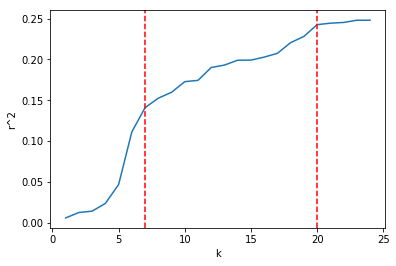

In [34]:
sns.lineplot(x='k',y='r^2',data=r_2)
plt.axvline(x=7, color = 'r', linestyle = '--')
plt.axvline(x=20, color = 'r', linestyle = '--')

"Knees" in the plot at around $k=7$ and $k=20$.

In [35]:
k = 7
linPCA_k7_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    linpcaZ = pd.DataFrame(linPCA(X_train, X_train, n_components=k))
    linPCA_k7_results[i] = LinRegression(linpcaZ, y, autocor = 2)

In [36]:
linPCA_k7_results

array([0.1735768 , 0.09166619, 0.07300708, 0.13263591, 0.14081481])

In [37]:
k = 20
linPCA_k20_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    linpcaZ = pd.DataFrame(linPCA(X_train, X_train, n_components=k))
    linPCA_k20_results[i] = LinRegression(linpcaZ, y, autocor = 2)

In [38]:
np.round(linPCA_k20_results,2)

array([0.29, 0.22, 0.2 , 0.24, 0.24])

Kernel PCA

In [41]:
# Polynomial kernel
k = 7
gamma = 1
degree = 2
poly_kpcaZ = pd.DataFrame(KPCA(X_train, X_train, n_components=k, kernel='poly', gamma = gamma, degree=degree))
LinRegression(poly_kpcaZ, y)

0.016011521530103878

In [42]:
gamma = 1
degree = 2
r_2 = np.zeros(24)
for i in range(1, 25):
    k=i
    poly_kpcaZ = pd.DataFrame(KPCA(X_train, X_train, n_components=k, kernel='poly', gamma = gamma, degree=degree))
    r_2[i-1]=LinRegression(poly_kpcaZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['k'] = range(1,25)

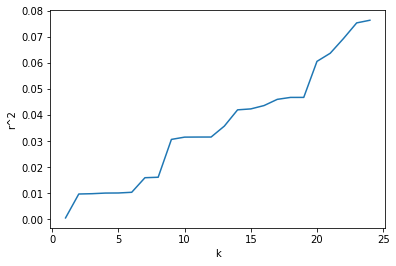

In [43]:
sns.lineplot(x='k',y='r^2',data=r_2)

With polynomial kernel w/ 2 degrees, steady increase with more components.

In [71]:
k=24
degree = 2
r_2 = np.zeros(50)
vals= np.linspace(-1, 1, 50)
for i, v in enumerate(vals):
    gamma = v
    poly_kpcaZ = pd.DataFrame(KPCA(X_train, X_train, n_components=k, kernel='poly', gamma = gamma, degree=degree))
    r_2[i]=LinRegression(poly_kpcaZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['gamma'] = vals

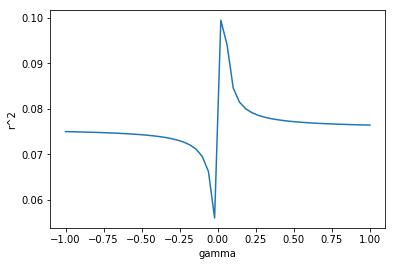

In [72]:
sns.lineplot(x='gamma',y='r^2',data=r_2);

Gamma should be positive, but as close to 0 as possible.

In [73]:
k = 20
gamma = 0.00001
degree = 2
KPCA_poly_k20_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    kpcaZ = pd.DataFrame(KPCA(X_train, X_train, n_components=k, gamma = gamma, kernel = 'poly', degree = degree))
    KPCA_poly_k20_results[i] = LinRegression(kpcaZ, y)
print(np.round(KPCA_k20_results,2))

[0.28 0.21 0.2  0.25 0.22]


In [74]:
# RBF Kernel
k = 20
gamma = 0.0001
rbf_kpcaZ = pd.DataFrame(KPCA(X_train, X_train, n_components=k, kernel='rbf', gamma = gamma))
LinRegression(rbf_kpcaZ, y)
KPCA_k20_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    kpcaZ = pd.DataFrame(KPCA(X_train, X_train, n_components=k, gamma = gamma, kernel = 'rbf'))
    KPCA_k20_results[i] = LinRegression(kpcaZ, y)
print(np.round(KPCA_k20_results,2))

[0.28 0.21 0.2  0.25 0.22]


Isomap

In [63]:
k_comp = 4
k_nn = 5
isomapZ = pd.DataFrame(isomap(X_train, X_train, n_components=k_comp, n_neighbors=k_nn))
LinRegression(isomapZ, y)

0.022929181978184054

In [77]:
k_nn = 5
r_2 = np.zeros(24)
for i in range(1, 25):
    k_comp=i
    isomapZ = pd.DataFrame(isomap(X_train, X_train, n_components=k_comp, n_neighbors=k_nn))
    r_2[i-1]=LinRegression(isomapZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['k'] = range(1,25)

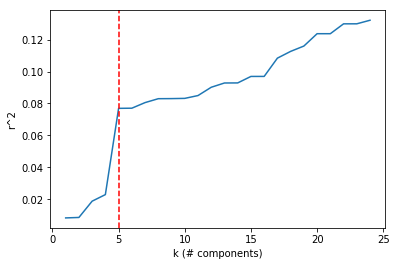

In [78]:
sns.lineplot(x='k',y='r^2',data=r_2)
plt.axvline(x=5, color = 'r', linestyle = '--')
plt.xlabel('k (# components)');

Big gains at $k=5$, linear thereafter.

In [79]:
k_comp = 5
r_2 = np.zeros(50)
for i in range(1, 51):
    k_nn=i
    isomapZ = pd.DataFrame(isomap(X_train, X_train, n_components=k_comp, n_neighbors=k_nn))
    r_2[i-1]=LinRegression(isomapZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['k'] = range(1,51)

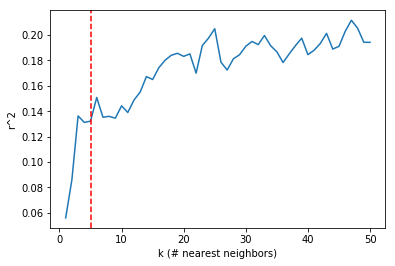

In [80]:
sns.lineplot(x='k',y='r^2',data=r_2)
plt.axvline(x=5, color = 'r', linestyle = '--')
plt.xlabel('k (# nearest neighbors)');

Again, big gains at $k=5$, unclear after that.

In [108]:
k = 20
nebs = 47
isomap_k7_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    isomapZ = pd.DataFrame(isomap(X_train, X_train, n_components=k, n_neighbors = nebs))
    isomap_k7_results[i] = LinRegression(isomapZ, y)
isomap_k7_results

array([0.24586509, 0.16389981, 0.15618824, 0.20639306, 0.15787926])

Spectral Embedding

In [91]:
k_comp = 24
k_nn = 6
affinity = 'nearest_neighbors'
spectralZ = pd.DataFrame(spectral(X_train, n_components=k_comp, n_neighbors=k_nn, affinity=affinity))
LinRegression(spectralZ, y)

0.08003289094716437

In [93]:
k_nn= 6
affinity = 'nearest_neighbors'
r_2 = np.zeros(24)
for i in range(1, 25):
    k_comp=i
    spectralZ = pd.DataFrame(spectral(X_train, n_components=k_comp, n_neighbors=k_nn, affinity = affinity))
    r_2[i-1]=LinRegression(spectralZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['k'] = range(1,25)

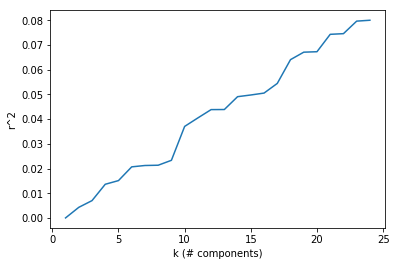

In [94]:
sns.lineplot(x='k',y='r^2',data=r_2);
plt.xlabel('k (# components)');

Steady linear increase with increasing components.

In [90]:
k_comp = 24
affinity = 'nearest_neighbors'
r_2 = np.zeros(50)
for i in range(1, 51):
    k_nn=i
    spectralZ = pd.DataFrame(spectral(X_train, n_components=k_comp, n_neighbors=k_nn, affinity = affinity))
    r_2[i-1]=LinRegression(spectralZ, y, autocor = 2)
r_2 = pd.DataFrame(r_2, columns=['r^2'])
r_2['k'] = range(1,51)

/Users/josephdenby/anaconda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


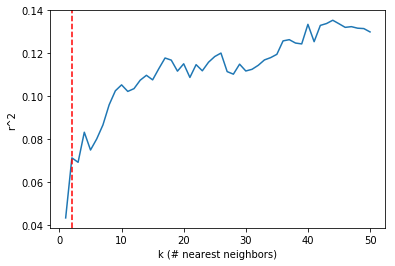

In [92]:
sns.lineplot(x='k',y='r^2',data=r_2);
plt.xlabel('k (# nearest neighbors)');
plt.axvline(x=2, color = 'r', linestyle = '--');

Stark gains at $k=2$; highly variable after that, but general trend upwards

In [95]:
k_comp= 20
k_nn = 3
affinity = 'nearest_neighbors'
spectral_results = np.zeros(5)
for i,s in enumerate(stocks.columns):
    y = stocks[[s]]
    spectralZ = pd.DataFrame(spectral(X_train, n_components=k_comp, n_neighbors=k_nn, affinity = affinity))
    spectral_results[i] = LinRegression(spectralZ, y)
print(np.round(spectral_results,2))

[0.1  0.08 0.08 0.09 0.06]
